# Imports


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Load data


In [10]:
baseline = pd.read_csv('baseline.csv')
experiment = pd.read_csv('experiment.csv')

baseline_error = baseline['error_angle_deg'].to_numpy()
experiment_error = experiment['error_angle_deg'].to_numpy()

print('Baseline trials:', len(baseline_error))
print('Experiment trials:', len(experiment_error))
print('Baseline missing:', np.isnan(baseline_error).sum())
print('Experiment missing:', np.isnan(experiment_error).sum())


Baseline trials: 160
Experiment trials: 400
Baseline missing: 2
Experiment missing: 9


# Plot errors with sections


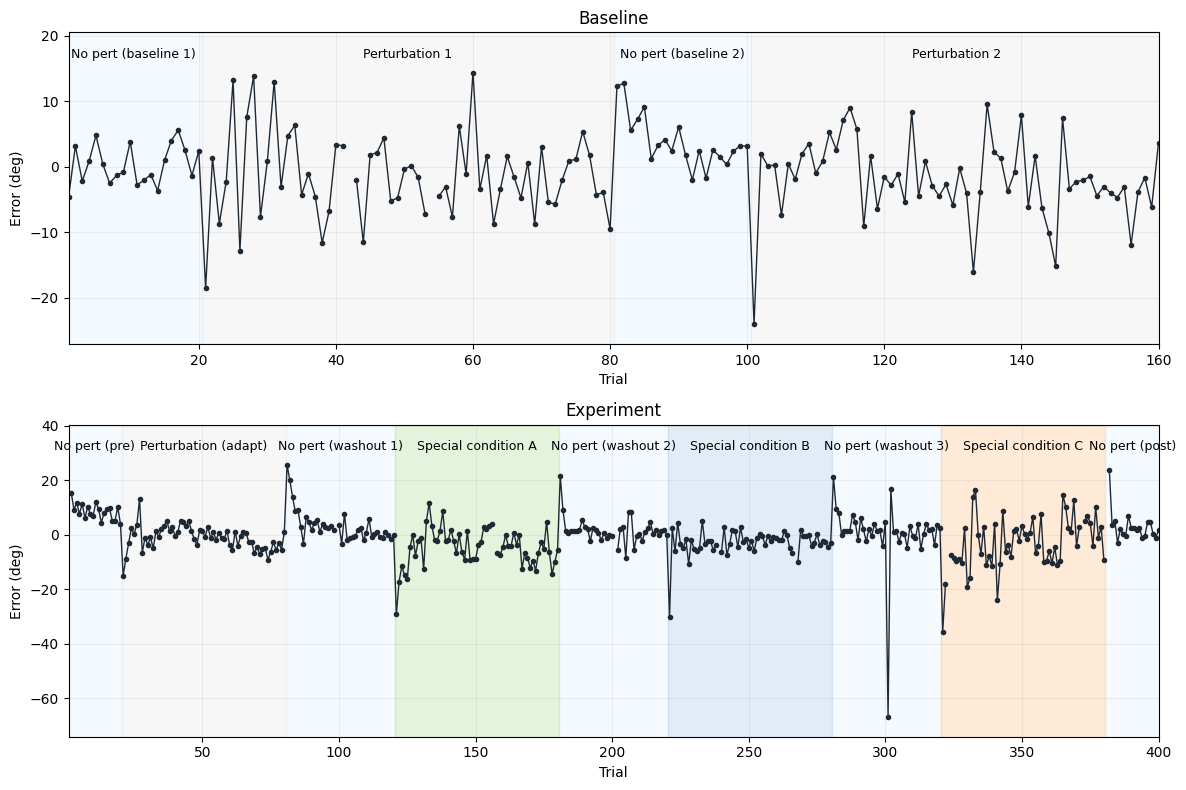

In [11]:
def build_segments(lengths, labels, colors, types):
    segments = []
    start = 1
    for length, label, color, seg_type in zip(lengths, labels, colors, types):
        end = start + length - 1
        segments.append({
            'start': start,
            'end': end,
            'label': label,
            'color': color,
            'type': seg_type,
        })
        start = end + 1
    return segments

def plot_error_with_segments(ax, errors, segments, title):
    x = np.arange(1, len(errors) + 1)
    ax.plot(x, errors, marker='o', markersize=3, linewidth=1, color='#1f2933')

    y_min = float(np.nanmin(errors))
    y_max = float(np.nanmax(errors))
    pad = max((y_max - y_min) * 0.08, 1.0)
    label_y = y_max + pad * 0.6

    for seg in segments:
        ax.axvspan(seg['start'] - 0.5, seg['end'] + 0.5, color=seg['color'], alpha=0.2)
        mid = (seg['start'] + seg['end']) / 2
        ax.text(mid, label_y, seg['label'], ha='center', va='bottom', fontsize=9)

    ax.set_xlim(1, len(errors))
    ax.set_ylim(y_min - pad, y_max + pad * 2)
    ax.set_xlabel('Trial')
    ax.set_ylabel('Error (deg)')
    ax.set_title(title)
    ax.grid(True, alpha=0.2)

baseline_segments = build_segments(
    lengths=[20, 60, 20, 60],
    labels=[
        'No pert (baseline 1)',
        'Perturbation 1',
        'No pert (baseline 2)',
        'Perturbation 2',
    ],
    colors=['#cfe8ff', '#d9d9d9', '#cfe8ff', '#d9d9d9'],
    types=['no_pert', 'perturbation', 'no_pert', 'perturbation'],
)

experiment_segments = build_segments(
    lengths=[20, 60, 40, 60, 40, 60, 40, 60, 20],
    labels=[
        'No pert (pre)',
        'Perturbation (adapt)',
        'No pert (washout 1)',
        'Special condition A',
        'No pert (washout 2)',
        'Special condition B',
        'No pert (washout 3)',
        'Special condition C',
        'No pert (post)',
    ],
    colors=[
        '#cfe8ff',
        '#d9d9d9',
        '#cfe8ff',
        '#78c850',
        '#cfe8ff',
        '#6fa3d8',
        '#cfe8ff',
        '#ff9a3c',
        '#cfe8ff',
    ],
    types=[
        'no_pert',
        'perturbation',
        'no_pert',
        'special',
        'no_pert',
        'special',
        'no_pert',
        'special',
        'no_pert',
    ],
)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
plot_error_with_segments(axes[0], baseline_error, baseline_segments, 'Baseline')
plot_error_with_segments(axes[1], experiment_error, experiment_segments, 'Experiment')
plt.tight_layout()


# After-effect analysis and baseline variability


In [12]:
def compute_aftereffects(errors, segments, n_after=5):
    rows = []
    for i, seg in enumerate(segments[:-1]):
        if seg['type'] in {'perturbation', 'special'}:
            next_seg = segments[i + 1]
            if next_seg['type'] != 'no_pert':
                continue
            start_idx = next_seg['start'] - 1
            end_idx = min(start_idx + n_after, next_seg['end'])
            window = errors[start_idx:end_idx]
            rows.append({
                'block': seg['label'],
                'after_segment': next_seg['label'],
                'after_n_trials': len(window),
                'after_mean_error_deg': float(np.nanmean(window)),
            })
    return pd.DataFrame(rows)

baseline_after = compute_aftereffects(baseline_error, baseline_segments, n_after=5)
experiment_after = compute_aftereffects(experiment_error, experiment_segments, n_after=5)

baseline_no_pert = []
for seg in baseline_segments:
    if seg['type'] == 'no_pert':
        start_idx = seg['start'] - 1
        end_idx = seg['end']
        baseline_no_pert.append(baseline_error[start_idx:end_idx])
baseline_no_pert = np.concatenate(baseline_no_pert)
baseline_motor_variability = float(np.nanstd(baseline_no_pert, ddof=1))

print('Baseline motor variability (std of no-pert trials):', round(baseline_motor_variability, 3))
display(pd.DataFrame({
    'baseline_motor_variability_std': [baseline_motor_variability]
}))

display(baseline_after)
display(experiment_after)


Baseline motor variability (std of no-pert trials): 3.927


,baseline_motor_variability_std
0,3.926999


,block,after_segment,after_n_trials,after_mean_error_deg
0,Perturbation 1,No pert (baseline 2),5,9.397099


,block,after_segment,after_n_trials,after_mean_error_deg
0,Perturbation (adapt),No pert (washout 1),5,15.446322
1,Special condition A,No pert (washout 2),5,6.776607
2,Special condition B,No pert (washout 3),5,7.986564
3,Special condition C,No pert (post),5,7.394497
